### import and read data

In [1]:
import json
import math
import os

import numpy as np
import pandas as pd
from keras import layers
from tensorflow import keras
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    # Nếu có GPU, in ra thông tin của từng GPU
    for gpu in physical_devices:
        # Lấy thông tin chi tiết của GPU
        gpu_details = tf.config.experimental.get_device_details(gpu)
        
        # # In ra tên và dung lượng RAM của GPU
        print("GPU Device:", gpu_details["device_name"])
else:
    print("No GPU available, TensorFlow is using CPU.")


GPU Device: NVIDIA GeForce RTX 2070


In [3]:
WORK_PATH = 'C:/Users/ADMIN/Contacts/KLTN/data'
SAVE_PATH = 'C:/Users/ADMIN/Contacts/KLTN/model'

In [4]:

# batch_size = 16
batch_size = 64
IMG_HEIGHT = int(224)
IMG_WIDTH = int(224)

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_balan'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))



Found 1476 images belonging to 5 classes.


### Resnet101

In [6]:
def build_model_resnet101():
    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
    model = tf.keras.applications.ResNet101(include_top= False, weights= 'imagenet', input_tensor= inputs)
    x = model.output
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Dropout(0.7)(x)
    outputs = keras.layers.Dense(5,activation= 'softmax')(x)
    model = keras.Model(inputs=inputs, outputs = outputs,name="model_use_ResNet101")
    # Đóng băng 1 phần mô hình
    l = len(model.layers)
    for i, layer in enumerate(model.layers):
        if i <= 0.8*l: layer.trainable = False
    return model


In [7]:
"Flatten, Dense 256-128-64-32, Dropout(0.5)"

'Flatten, Dense 256-128-64-32, Dropout(0.5)'

In [8]:
def load_images(file_paths):
    if file_paths:
        images = []
        for file_path in file_paths:
            img = keras.utils.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = keras.utils.img_to_array(img)
            img = img / 255.0
            images.append(img)
        return np.array(images)
def predict_images(model, file_paths):
    images = load_images(file_paths)
    # predictions = np.argmax(model.predict(images), axis = 1)
    # return np.array([labels[i] for i in predictions])
    return model.predict(images)
# y_pred = predict_images(model,[os.path.join(SAVE_PATH,"2496_right.jpeg"),os.path.join(SAVE_PATH,"99_left.jpeg")])
# np.argmax(y_pred, axis=1)

In [9]:
No_DR = 17295
Mild =3581
Moderate = 1641
Severe = 605
Proliferative_DR = 470
total=No_DR + Mild + Proliferative_DR + Severe + Moderate

weight_for_0 = (1 / Mild) * (total / 5.0)
weight_for_1 = (1 / Moderate) * (total / 5.0)
weight_for_2 = (1 / No_DR) * (total / 5.0)
weight_for_3 = (1 / Proliferative_DR) * (total / 5.0)
weight_for_4 = (1 / Severe) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}
class_weight


{0: 1.3176207763194636,
 1: 2.8753199268738574,
 2: 0.2728187337380746,
 3: 10.039148936170212,
 4: 7.799008264462809}

#### 1

In [13]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_v1.h5')) #weight with data banlace


In [51]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_1'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_1'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [15]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_resnet101_vfold1.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
# callbacks = [callbacks_1,callbacks_2]

In [16]:
#Training model
history = model.fit(i_train,validation_data = i_val ,epochs = 70,callbacks = callbacks,class_weight=class_weight)


Epoch 1/70
352/352 [==============================] - 175s 471ms/step - loss: 1.5421 - accuracy: 0.3364 - val_loss: 1.0923 - val_accuracy: 0.4330
Epoch 2/70
352/352 [==============================] - 160s 453ms/step - loss: 1.2649 - accuracy: 0.3455 - val_loss: 1.0059 - val_accuracy: 0.4826
Epoch 3/70
352/352 [==============================] - 155s 440ms/step - loss: 1.2118 - accuracy: 0.3749 - val_loss: 1.1233 - val_accuracy: 0.4711
Epoch 4/70
352/352 [==============================] - 158s 449ms/step - loss: 1.1540 - accuracy: 0.3862 - val_loss: 1.0003 - val_accuracy: 0.5469
Epoch 5/70
352/352 [==============================] - 155s 441ms/step - loss: 1.1108 - accuracy: 0.4009 - val_loss: 1.0831 - val_accuracy: 0.5368
Epoch 6/70
352/352 [==============================] - 156s 443ms/step - loss: 1.0862 - accuracy: 0.4143 - val_loss: 1.4194 - val_accuracy: 0.3381
Epoch 7/70
352/352 [==============================] - 154s 436ms/step - loss: 1.0660 - accuracy: 0.4169 - val_loss: 1.4297 -

In [52]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet101_vfold1.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

In [53]:
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print("val:")
model.evaluate(i_val)
print("test:")
model.evaluate(i_test)


Found 7022 images belonging to 5 classes.
val:
88/88 [==============================] - 32s 329ms/step - loss: 1.0005 - accuracy: 0.7390
test:
110/110 [==============================] - 31s 279ms/step - loss: 1.5370 - accuracy: 0.6672


[1.5370218753814697, 0.667188823223114]

In [17]:
columns = ["model_name","layer", "fold", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['layer'] = "GlobalAvgPool2D, Dropout(0.7)"
history_df['epoch'] = history_df.index+1
history_df['fold'] = 1
history_df= history_df.reindex(columns=columns)
history_df.to_csv('history_fit.csv', index=False,mode='a',header = False)

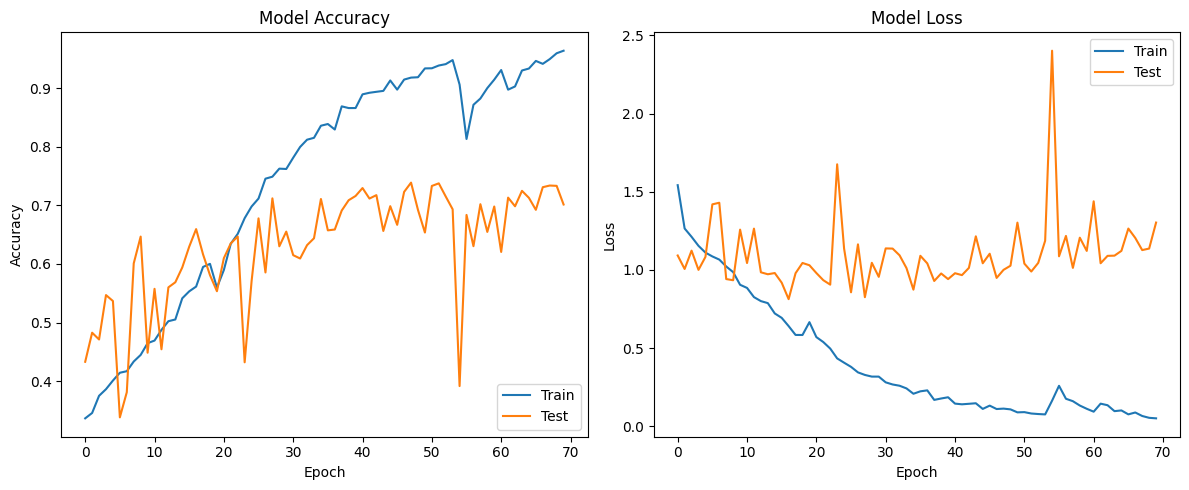

In [18]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

#### 2

In [41]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_v1.h5')) #weight with data banlace


In [42]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_2'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_2'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22468 images belonging to 5 classes.
Found 5618 images belonging to 5 classes.


In [43]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_resnet101_vfold2.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
# callbacks = [callbacks_1,callbacks_2]

In [44]:
#Training model
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
352/352 [==============================] - 162s 446ms/step - loss: 1.5121 - accuracy: 0.3456 - val_loss: 1.0788 - val_accuracy: 0.4242
Epoch 2/100
352/352 [==============================] - 151s 428ms/step - loss: 1.2593 - accuracy: 0.3466 - val_loss: 1.1702 - val_accuracy: 0.3631
Epoch 3/100
352/352 [==============================] - 156s 442ms/step - loss: 1.2192 - accuracy: 0.3631 - val_loss: 1.0138 - val_accuracy: 0.4726
Epoch 4/100
352/352 [==============================] - 156s 444ms/step - loss: 1.2030 - accuracy: 0.3805 - val_loss: 0.9091 - val_accuracy: 0.5723
Epoch 5/100
352/352 [==============================] - 151s 428ms/step - loss: 1.1711 - accuracy: 0.3809 - val_loss: 0.9341 - val_accuracy: 0.5509
Epoch 6/100
352/352 [==============================] - 151s 428ms/step - loss: 1.0995 - accuracy: 0.4094 - val_loss: 1.1746 - val_accuracy: 0.4096
Epoch 7/100
352/352 [==============================] - 155s 441ms/step - loss: 1.0602 - accuracy: 0.4067 - val_loss: 1

In [49]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet101_vfold2.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

In [50]:
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print("val:")
model.evaluate(i_val)
print("test:")
model.evaluate(i_test)


Found 7022 images belonging to 5 classes.
val:
88/88 [==============================] - 28s 282ms/step - loss: 1.0407 - accuracy: 0.7617
test:
110/110 [==============================] - 38s 348ms/step - loss: 1.6157 - accuracy: 0.7029


[1.615689754486084, 0.7029336094856262]

In [45]:
columns = ["model_name","layer", "fold", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['layer'] = "GlobalAvgPool2D, Dropout(0.7)"
history_df['epoch'] = history_df.index+1
history_df['fold'] = 2
history_df= history_df.reindex(columns=columns)
history_df.to_csv('history_fit.csv', index=False,mode='a',header = False)

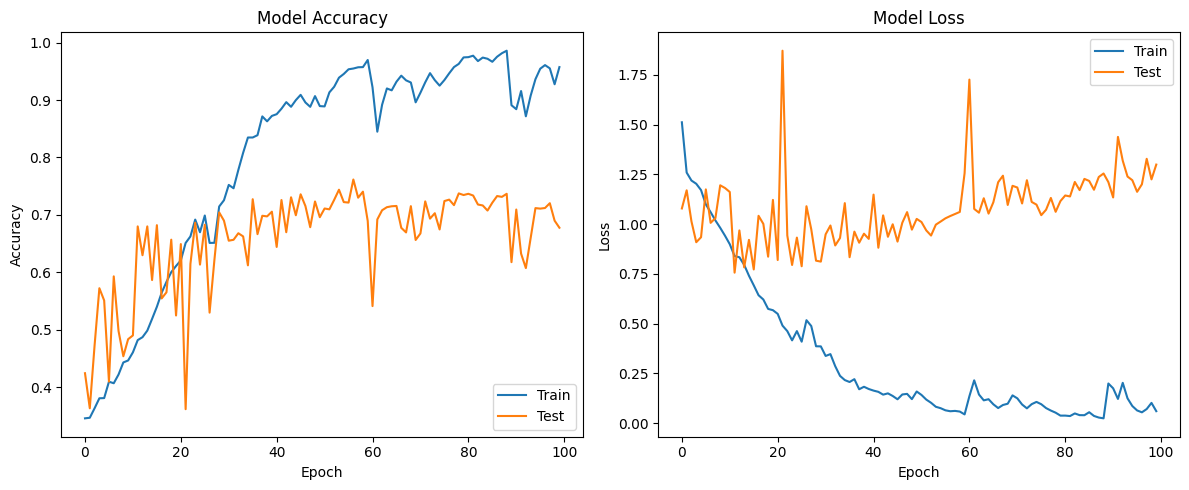

In [46]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

#### 3

In [23]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_v1.h5')) #weight with data banlace


In [54]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_3'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_3'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5689 images belonging to 5 classes.


In [25]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_resnet101_vfold3.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
# callbacks = [callbacks_1,callbacks_2]

In [26]:
#Training model
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
352/352 [==============================] - 178s 489ms/step - loss: 1.5061 - accuracy: 0.3422 - val_loss: 1.0832 - val_accuracy: 0.4234
Epoch 2/100
352/352 [==============================] - 166s 470ms/step - loss: 1.2791 - accuracy: 0.3403 - val_loss: 0.9573 - val_accuracy: 0.5245
Epoch 3/100
352/352 [==============================] - 161s 456ms/step - loss: 1.2227 - accuracy: 0.3595 - val_loss: 1.1445 - val_accuracy: 0.4129
Epoch 4/100
352/352 [==============================] - 160s 456ms/step - loss: 1.1961 - accuracy: 0.3807 - val_loss: 1.1460 - val_accuracy: 0.4498
Epoch 5/100
352/352 [==============================] - 165s 470ms/step - loss: 1.1469 - accuracy: 0.3812 - val_loss: 0.9861 - val_accuracy: 0.5528
Epoch 6/100
352/352 [==============================] - 161s 456ms/step - loss: 1.1017 - accuracy: 0.3933 - val_loss: 1.2226 - val_accuracy: 0.4296
Epoch 7/100
352/352 [==============================] - 160s 456ms/step - loss: 1.0614 - accuracy: 0.4162 - val_loss: 1

In [55]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet101_vfold3.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print("val:")
model.evaluate(i_val)
print("test:")
model.evaluate(i_test)


Found 7022 images belonging to 5 classes.
val:
89/89 [==============================] - 32s 332ms/step - loss: 1.0100 - accuracy: 0.7595
test:
110/110 [==============================] - 31s 283ms/step - loss: 1.5980 - accuracy: 0.6883


[1.5980195999145508, 0.6882654428482056]

In [27]:
columns = ["model_name","layer", "fold", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['layer'] = "GlobalAvgPool2D, Dropout(0.7)"
history_df['epoch'] = history_df.index+1
history_df['fold'] = 3
history_df= history_df.reindex(columns=columns)
history_df.to_csv('history_fit.csv', index=False,mode='a',header = False)

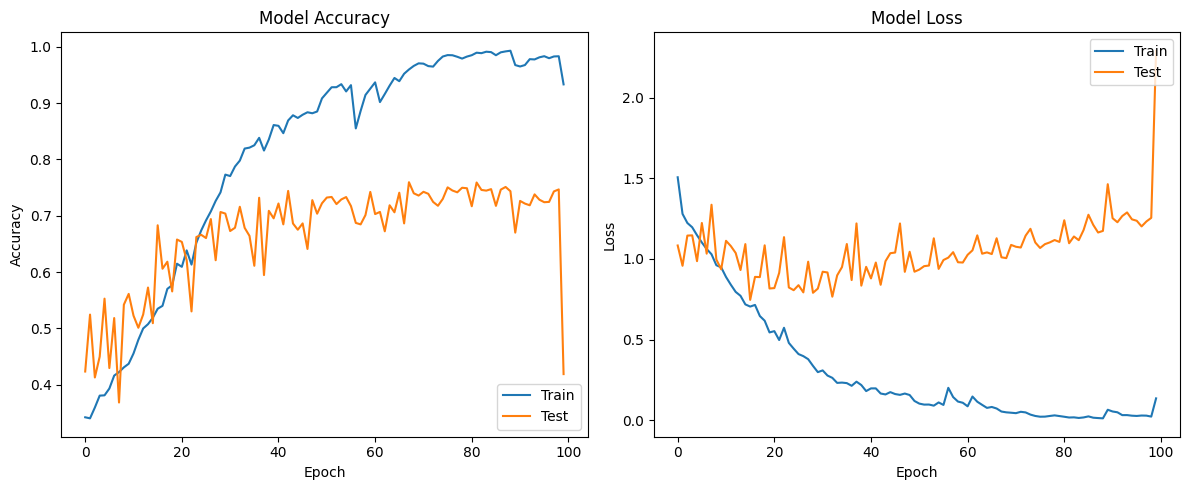

In [28]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

#### 4

In [29]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_v1.h5')) #weight with data banlace


In [57]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_4'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_4'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22541 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [31]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_resnet101_vfold4.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
# callbacks = [callbacks_1,callbacks_2]

In [32]:
#Training model
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
353/353 [==============================] - 155s 423ms/step - loss: 1.5742 - accuracy: 0.3453 - val_loss: 0.9351 - val_accuracy: 0.5271
Epoch 2/100
353/353 [==============================] - 131s 369ms/step - loss: 1.2819 - accuracy: 0.3333 - val_loss: 0.8722 - val_accuracy: 0.5786
Epoch 3/100
353/353 [==============================] - 131s 370ms/step - loss: 1.2292 - accuracy: 0.3552 - val_loss: 0.8858 - val_accuracy: 0.6425
Epoch 4/100
353/353 [==============================] - 130s 369ms/step - loss: 1.1818 - accuracy: 0.3767 - val_loss: 0.7917 - val_accuracy: 0.6993
Epoch 5/100
353/353 [==============================] - 126s 357ms/step - loss: 1.1341 - accuracy: 0.3942 - val_loss: 1.0641 - val_accuracy: 0.4889
Epoch 6/100
353/353 [==============================] - 126s 357ms/step - loss: 1.0941 - accuracy: 0.4006 - val_loss: 1.0827 - val_accuracy: 0.4773
Epoch 7/100
353/353 [==============================] - 126s 357ms/step - loss: 1.0499 - accuracy: 0.4160 - val_loss: 0

In [33]:
columns = ["model_name","layer", "fold", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['layer'] = "GlobalAvgPool2D, Dropout(0.7)"
history_df['epoch'] = history_df.index+1
history_df['fold'] = 4
history_df= history_df.reindex(columns=columns)
history_df.to_csv('history_fit.csv', index=False,mode='a',header = False)

In [58]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet101_vfold4.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print("val:")
model.evaluate(i_val)
print("test:")
model.evaluate(i_test)


Found 7022 images belonging to 5 classes.
val:
88/88 [==============================] - 32s 334ms/step - loss: 1.1859 - accuracy: 0.7675
test:
110/110 [==============================] - 31s 286ms/step - loss: 1.9189 - accuracy: 0.6921


[1.918940544128418, 0.692110538482666]

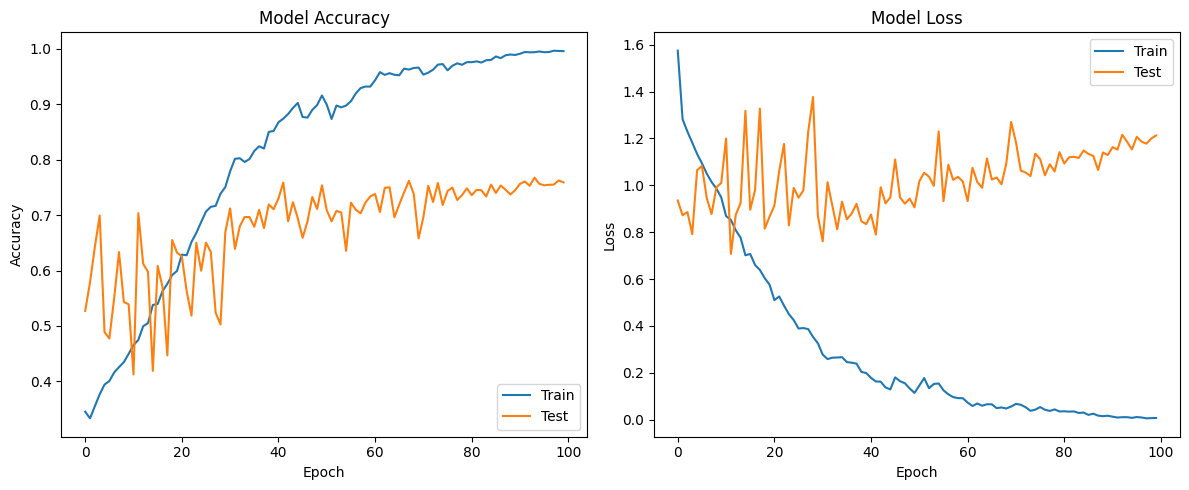

In [34]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

#### 5

In [35]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_v1.h5')) #weight with data banlace

In [59]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_5'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_5'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [37]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_resnet101_vfold5.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
# callbacks = [callbacks_1,callbacks_2]

In [38]:
#Training model
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
352/352 [==============================] - 166s 456ms/step - loss: 1.5687 - accuracy: 0.3547 - val_loss: 0.9352 - val_accuracy: 0.5907
Epoch 2/100
352/352 [==============================] - 152s 431ms/step - loss: 1.2877 - accuracy: 0.3593 - val_loss: 0.8857 - val_accuracy: 0.5565
Epoch 3/100
352/352 [==============================] - 152s 431ms/step - loss: 1.2400 - accuracy: 0.3651 - val_loss: 0.9822 - val_accuracy: 0.5743
Epoch 4/100
352/352 [==============================] - 157s 445ms/step - loss: 1.1963 - accuracy: 0.3680 - val_loss: 0.8975 - val_accuracy: 0.6169
Epoch 5/100
352/352 [==============================] - 152s 431ms/step - loss: 1.1703 - accuracy: 0.3783 - val_loss: 1.2002 - val_accuracy: 0.4278
Epoch 6/100
352/352 [==============================] - 152s 431ms/step - loss: 1.1223 - accuracy: 0.3936 - val_loss: 1.1043 - val_accuracy: 0.4488
Epoch 7/100
352/352 [==============================] - 152s 431ms/step - loss: 1.0834 - accuracy: 0.4084 - val_loss: 1

In [60]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet101_vfold5.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
print("val:")
model.evaluate(i_val)
print("test:")
model.evaluate(i_test)


Found 7022 images belonging to 5 classes.
val:
88/88 [==============================] - 32s 332ms/step - loss: 1.2397 - accuracy: 0.7629
test:
110/110 [==============================] - 32s 288ms/step - loss: 1.9278 - accuracy: 0.6944


[1.9278111457824707, 0.6943890452384949]

In [39]:
columns = ["model_name","layer", "fold", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['layer'] = "GlobalAvgPool2D, Dropout(0.7)"
history_df['epoch'] = history_df.index+1
history_df['fold'] = 5
history_df= history_df.reindex(columns=columns)
history_df.to_csv('history_fit.csv', index=False,mode='a',header = False)

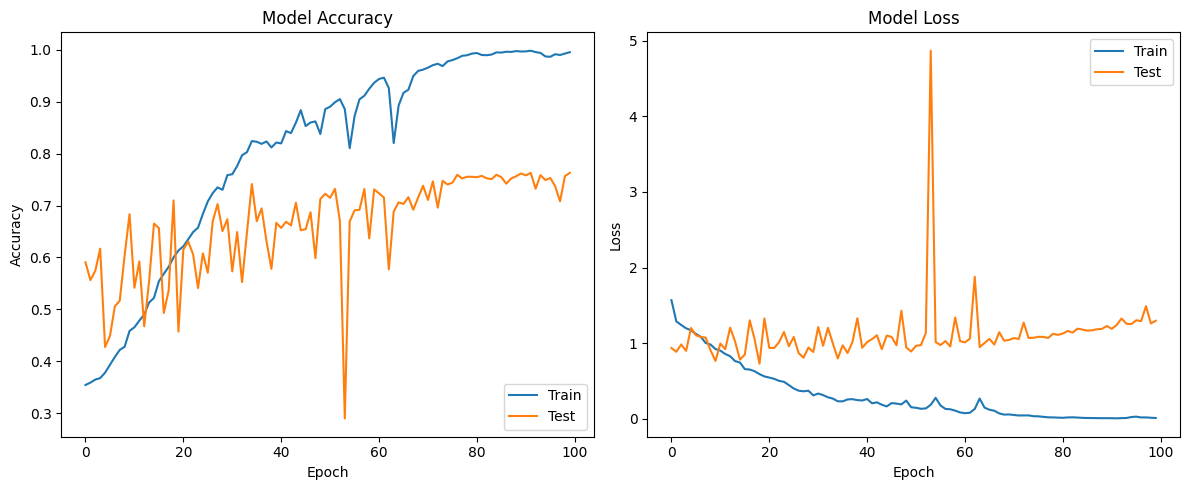

In [40]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

### Train_all


In [10]:
No_DR = 17295
Mild =3581
Moderate = 1641
Severe = 605
Proliferative_DR = 470
total=No_DR + Mild + Proliferative_DR + Severe + Moderate

weight_for_0 = (1 / Mild) * (total / 5.0)
weight_for_1 = (1 / Moderate) * (total / 5.0)
weight_for_2 = (1 / No_DR) * (total / 5.0)
weight_for_3 = (1 / Proliferative_DR) * (total / 5.0)
weight_for_4 = (1 / Severe) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}
class_weight

{0: 1.3176207763194636,
 1: 2.8753199268738574,
 2: 0.2728187337380746,
 3: 10.039148936170212,
 4: 7.799008264462809}

In [11]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data

i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'Train_all'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

test_image_generator = ImageDataGenerator(rescale=1./255)
i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 28086 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


In [12]:
model = None
model = build_model_resnet101()
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

In [13]:
callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_Resnet101_final.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]



In [14]:
history = model.fit(i_train,validation_data = i_test ,epochs = 200,callbacks = callbacks,class_weight=class_weight)


Epoch 1/200
439/439 [==============================] - 171s 368ms/step - loss: 1.7754 - accuracy: 0.1697 - val_loss: 1.6451 - val_accuracy: 0.1450
Epoch 2/200
439/439 [==============================] - 153s 348ms/step - loss: 1.6640 - accuracy: 0.1652 - val_loss: 1.7984 - val_accuracy: 0.1319
Epoch 3/200
439/439 [==============================] - 153s 349ms/step - loss: 1.6208 - accuracy: 0.1656 - val_loss: 1.6960 - val_accuracy: 0.1273
Epoch 4/200
439/439 [==============================] - 153s 348ms/step - loss: 1.6073 - accuracy: 0.1678 - val_loss: 1.6422 - val_accuracy: 0.1407
Epoch 5/200
439/439 [==============================] - 158s 359ms/step - loss: 1.5863 - accuracy: 0.1728 - val_loss: 1.4568 - val_accuracy: 0.1548
Epoch 6/200
439/439 [==============================] - 159s 361ms/step - loss: 1.5754 - accuracy: 0.1777 - val_loss: 1.4359 - val_accuracy: 0.1833
Epoch 7/200
439/439 [==============================] - 153s 348ms/step - loss: 1.5734 - accuracy: 0.1835 - val_loss: 1

In [16]:
callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_Resnet101_final1.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]



In [17]:
history = model.fit(i_train,validation_data = i_test ,epochs = 15,callbacks = callbacks,class_weight=class_weight)


Epoch 1/15
439/439 [==============================] - 175s 397ms/step - loss: 0.4250 - accuracy: 0.7191 - val_loss: 1.1244 - val_accuracy: 0.6664
Epoch 2/15
439/439 [==============================] - 155s 353ms/step - loss: 0.1831 - accuracy: 0.8524 - val_loss: 1.4831 - val_accuracy: 0.5587
Epoch 3/15
439/439 [==============================] - 155s 353ms/step - loss: 0.1438 - accuracy: 0.8874 - val_loss: 1.3329 - val_accuracy: 0.6455
Epoch 4/15
439/439 [==============================] - 155s 353ms/step - loss: 0.1239 - accuracy: 0.9014 - val_loss: 2.2885 - val_accuracy: 0.4874
Epoch 5/15
439/439 [==============================] - 155s 353ms/step - loss: 0.1104 - accuracy: 0.9126 - val_loss: 1.4668 - val_accuracy: 0.6526
Epoch 6/15
439/439 [==============================] - 155s 354ms/step - loss: 0.0859 - accuracy: 0.9311 - val_loss: 1.6129 - val_accuracy: 0.6077
Epoch 7/15
439/439 [==============================] - 155s 353ms/step - loss: 0.0785 - accuracy: 0.9380 - val_loss: 1.6040 -

In [22]:
history = model.fit(i_train,validation_data = i_test ,epochs = 15,callbacks = callbacks,class_weight=class_weight)


Epoch 1/15
439/439 [==============================] - 155s 352ms/step - loss: 0.0761 - accuracy: 0.9399 - val_loss: 1.1300 - val_accuracy: 0.7127
Epoch 2/15
439/439 [==============================] - 154s 352ms/step - loss: 0.0523 - accuracy: 0.9577 - val_loss: 1.1009 - val_accuracy: 0.7275
Epoch 3/15
439/439 [==============================] - 154s 352ms/step - loss: 0.0677 - accuracy: 0.9530 - val_loss: 1.3507 - val_accuracy: 0.6627
Epoch 4/15
439/439 [==============================] - 155s 352ms/step - loss: 0.0650 - accuracy: 0.9518 - val_loss: 1.3082 - val_accuracy: 0.6781
Epoch 5/15
439/439 [==============================] - 154s 352ms/step - loss: 0.0504 - accuracy: 0.9633 - val_loss: 1.2450 - val_accuracy: 0.7011
Epoch 6/15
439/439 [==============================] - 154s 352ms/step - loss: 0.0602 - accuracy: 0.9551 - val_loss: 1.1960 - val_accuracy: 0.7021
Epoch 7/15
439/439 [==============================] - 155s 352ms/step - loss: 0.0508 - accuracy: 0.9620 - val_loss: 1.2486 -

### Test

In [23]:
model = None
model = build_model_resnet101()
model.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_final1.h5')) #weight with data banlace
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

In [24]:
test_image_generator = ImageDataGenerator(rescale=1./255)

i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
result = model.evaluate(i_test)

Found 7023 images belonging to 5 classes.
110/110 [==============================] - 26s 216ms/step - loss: 1.1817 - accuracy: 0.7485
